In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from random import sample, seed
import random
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from transformers import BertForSequenceClassification
from transformers import BertTokenizer, BertModel
from transformers import BertConfig
from tqdm import tqdm
from IPython.display import clear_output
import time

from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [3]:
!pip install transformers
clear_output()

In [4]:
# read data
path = '/content/drive/MyDrive/Colab Notebooks/屏東孤老/'
# dat = pd.read_csv(os.path.join(path, '(加風險)109-110字串化.csv'))
dat = pd.read_csv(os.path.join(path, '(加風險)109-111字串化.csv'))
print(dat.shape)
# rename cols
dat.columns = ['ID', 'text', 'label']
# drop duplicates
dat = dat.drop_duplicates(subset=['ID'], keep='last')
dat = dat.reset_index(drop=True)
print(dat.shape)
print(Counter(dat['label']))

(5540, 3)
(4201, 3)
Counter({'低風險': 3884, '中高風險': 317})


In [5]:
# read data
death_ID2label = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/屏東孤老/death_ID2label.csv')
# update new labels
dat.loc[dat['ID'].isin(death_ID2label['ID']), 'label'] = '中高風險'
print(Counter(dat['label']))

Counter({'低風險': 3677, '中高風險': 524})


In [6]:
# remove index for string length > 512(模型需要)
remove_index = []
for i, x in enumerate(dat['text']):  
  if len(x) > 512:
    remove_index += [i]
dat = dat.drop(remove_index, axis=0).reset_index(drop=True)
print(len(remove_index))
print(dat.shape)

18
(4183, 3)


In [7]:
# split data
seed(1)
train_index = sample(range(dat.shape[0]), int(0.8*dat.shape[0]))
test_index = list(set(range(dat.shape[0])).difference(set(train_index)))
valid_index = sample(train_index, int(0.2*len(train_index)))
train_index = list(set(train_index).difference(set(valid_index)))
dat_train = dat.iloc[train_index,]
dat_valid = dat.iloc[valid_index,]
dat_test = dat.iloc[test_index,]
print('trian:', dat_train.shape) 
print('valid:', dat_valid.shape)
print('test:', dat_test.shape)

trian: (2677, 3)
valid: (669, 3)
test: (837, 3)


In [8]:
print('org:', Counter(dat_train['label']))
# data augmentation
mh_number = Counter(dat_train['label'])['中高風險'] # mid, hight
dat_train_upsampling = dat_train[dat_train['label']=='中高風險'].sample(n=500-mh_number, replace=True, random_state=1)
dat_train = pd.concat([dat_train, dat_train_upsampling])
print('aug:', Counter(dat_train['label']))

org: Counter({'低風險': 2366, '中高風險': 311})
aug: Counter({'低風險': 2366, '中高風險': 500})


In [9]:
# saved data(模型需要)
dat_train.loc[:,['text','label']].to_csv(os.path.join(path,'train.tsv'), sep="\t", index=False)
dat_valid.loc[:,['text','label']].to_csv(os.path.join(path,'valid.tsv'), sep="\t", index=False)
dat_test.loc[:,['text','label']].to_csv(os.path.join(path,'test.tsv'), sep="\t", index=False)

In [10]:
all_ID = dat['ID'].tolist()
len(all_ID)

4183

# Data preprocess for BERT

In [11]:
"""
實作一個可以用來讀取訓練 / 測試集的 Dataset, 這是你需要徹底了解的部分。
此 Dataset 每次將 tsv 裡的一筆成對句子轉換成 BERT 相容的格式，並回傳 3 個 tensors:
- tokens_tensor: 兩個句子合併後的索引序列，包含 [CLS] 與 [SEP]
- segments_tensor: 可以用來識別兩個句子界限的 binary tensor
- label_tensor: 將分類標籤轉換成類別索引的 tensor, 如果是測試集則回傳 None
"""

class FakeNewsDataset(Dataset):
    # 讀取前處理後的 tsv 檔並初始化一些參數
    def __init__(self, mode, tokenizer):
        assert mode in ["train", "valid", "test"]  # 一般訓練你會需要 dev set
        self.mode = mode
        # 大數據你會需要用 iterator=True
        self.df = pd.read_csv(os.path.join(path, f'{mode}.tsv'), sep="\t").fillna("")
        self.len = len(self.df)
        self.label_map = {'低風險': 0, '中高風險': 1}
        self.tokenizer = tokenizer  # 我們將使用 BERT tokenizer
    
    # 定義回傳一筆訓練 / 測試數據的函式
    def __getitem__(self, idx):
        if self.mode == "test":
            # text_a, text_b = self.df.iloc[idx, :2].values
            text = self.df.iloc[idx, 0] # 因為我們只有 text ,故不需要用.values
            label_tensor = None
        else:
            text, label = self.df.iloc[idx, :].values
            # 將 label 文字也轉換成索引方便轉換成 tensor
            label_id = self.label_map[label]
            label_tensor = torch.tensor(label_id)
            
        # # 建立第一個句子的 BERT tokens 並加入分隔符號 [SEP]
        # word_pieces = ["[CLS]"]
        # tokens_a = self.tokenizer.tokenize(text_a)
        # word_pieces += tokens_a + ["[SEP]"]
        # len_a = len(word_pieces)
        
        # # 第二個句子的 BERT tokens
        # tokens_b = self.tokenizer.tokenize(text_b)
        # word_pieces += tokens_b + ["[SEP]"]
        # len_b = len(word_pieces) - len_a

        # # 如果只有一句話 BERT tokens
        word_pieces = ["[CLS]"] # 開頭
        tokens = self.tokenizer.tokenize(text) # output: list
        word_pieces += tokens + ["[SEP]"] # 結尾
        len_ = len(word_pieces)
        
        # 將整個 token 序列轉換成索引序列
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        # 將第一句包含 [SEP] 的 token 位置設為 0, 其他為 1 表示第二句
        # segments_tensor = torch.tensor([0] * len_a + [1] * len_b, 
        #                                 dtype=torch.long)
        
        # 將第一句包含 [SEP] 的 token 位置設為 0, 因為只有一句話故全都是 0
        segments_tensor = torch.tensor([0] * len_, 
                                        dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    


In [12]:
# trainset.df.iloc[0]['text']

In [13]:
"""
實作可以一次回傳一個 mini-batch 的 DataLoader
這個 DataLoader 吃我們上面定義的 `FakeNewsDataset`,
回傳訓練 BERT 時會需要的 4 個 tensors:
- tokens_tensors  : (batch_size, max_seq_len_in_batch)
- segments_tensors: (batch_size, max_seq_len_in_batch)
- masks_tensors   : (batch_size, max_seq_len_in_batch)
- label_ids       : (batch_size)
"""

'''
其中, pad_sequence 是將不同長度的 tensor 補齊到相同長度的函式，
我們將 tokens_tensors 和 segments_tensors 分別傳給 pad_sequence 函式, 讓它們都補齊到 batch 中最長的序列的長度,
這樣做的好處是可以讓整個 batch 進行矩陣運算，加速模型的訓練。
'''
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# 這個函式的輸入 `samples` 是一個 list，裡頭的每個 element 都是
# 剛剛定義的 `FakeNewsDataset` 回傳的一個樣本，每個樣本都包含 3 tensors：
# - tokens_tensor
# - segments_tensor
# - label_tensor
# 它會對前兩個 tensors 作 zero padding，並產生前面說明過的 masks_tensors
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    # 測試集有 labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # zero pad 到同一序列長度, 取 batch 中最長的作為 padding 到的最大長度
    tokens_tensors = pad_sequence(tokens_tensors, 
                                  batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, 
                                    batch_first=True)
    
    # attention masks，將 tokens_tensors 裡頭不為 zero padding
    # 的位置設為 1 讓 BERT 只關注這些位置的 tokens
    masks_tensors = torch.zeros(tokens_tensors.shape, 
                                dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(
        tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids



In [14]:
# 利用 `collate_fn` 將 list of samples 合併成一個 mini-batch 是關鍵
BATCH_SIZE = 8
# 初始化一個專門讀取訓練樣本的 Dataset, 使用中文 BERT 斷詞
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
trainset = FakeNewsDataset("train", tokenizer=tokenizer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch,
                         shuffle=True, num_workers=0, pin_memory=True)

validset = FakeNewsDataset("valid", tokenizer=tokenizer)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, 
                        collate_fn=create_mini_batch,
                        shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
trainset.df
# validset.df

In [16]:
# 假設有三個序列，分別是 [1, 2, 3], [4, 5], [6]
seqs = [torch.tensor([1, 2, 3]), torch.tensor([4, 5]), torch.tensor([6])]

# 使用 pad_sequence 將這三個序列補到相同的長度
padded_seqs = pad_sequence(seqs, batch_first=True)
padded_seqs

tensor([[1, 2, 3],
        [4, 5, 0],
        [6, 0, 0]])

In [17]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([8, 366]) 
tensor([[ 101, 6857,  855,  ...,    0,    0,    0],
        [ 101, 6857,  855,  ..., 2692,  511,  102],
        [ 101, 6857,  855,  ...,    0,    0,    0],
        ...,
        [ 101, 6857,  855,  ...,    0,    0,    0],
        [ 101, 6857,  855,  ...,    0,    0,    0],
        [ 101, 6857,  855,  ...,    0,    0,    0]])
------------------------
segments_tensors.shape = torch.Size([8, 366])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------------------------
masks_tensors.shape    = torch.Size([8, 366])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
------------------------
label_ids.shape        

In [ ]:
# # 載入一個可以做中文多分類任務的模型, n_class = 2
# model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=2)
# clear_output()

# # high-level 顯示此模型裡的 modules
# print("""
# name            module
# ----------------------""")
# for name, module in model.named_children():
#     if name == "bert":
#         for n, _ in module.named_children():
#             print(f"{name}:{n}")
#     else:
#         print("{:15} {}".format(name, module))

# Model training

In [18]:
# "cuda" only when GPUs are available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# config
config = BertConfig.from_pretrained("bert-base-chinese")
config.num_labels = 2
# config.hidden_dropout_prob = 0.5

# load model
# pretrained_model_name = "bert-base-chinese"
# model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=2)
model = BertForSequenceClassification.from_pretrained("bert-base-chinese", config=config)
model = model.to(device)

# 使用 Adam Optim 更新整個分類模型的參數
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5) # weight_decay=1e-5 

# For the classification task, we use cross-entropy as the measurement of performance.
# weight = torch.tensor([1.0, 2.0]).to(device)
criterion = nn.CrossEntropyLoss()

# hyper-parameters
n_epochs = 30

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0
best_loss = 1e6
patience = 100

train_loss_recode = []
valid_loss_recode = []

for epoch in range(n_epochs):
  
  # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for data in tqdm(trainloader):
      
      # Forward the data. (Make sure data and model are on the same device.)
      tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

      # forward pass
      outputs = model(input_ids=tokens_tensors, 
                      token_type_ids=segments_tensors, 
                      attention_mask=masks_tensors)
      
      # logits
      logits = outputs[0]
      # print(logits)

      # loss
      loss = criterion(logits, labels)
      # print(loss)

      # Gradients stored in the parameters in the previous step should be cleared out first.
      optimizer.zero_grad()

      # Compute the gradients for parameters.
      loss.backward()

      # # Clip the gradient norms for stable training.
      grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

      # Update the parameters with computed gradients.
      optimizer.step()

      # Compute the accuracy for current batch.
      acc = (logits.argmax(dim=-1) == labels).float().mean()

      # Record the loss and accuracy.
      train_loss.append(loss.item())
      train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    
    train_loss_recode += [train_loss]

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")


    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    for data in tqdm(validloader):

      # Forward the data. (Make sure data and model are on the same device.)
      tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

      # We don't need gradient in validation.
      # Using torch.no_grad() accelerates the forward process.
      with torch.no_grad():
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors) # labels
        
      # We can still compute the loss (but not the gradient).
      logits = outputs[0]
      
      # We can still compute the loss (but not the gradient).
      loss = criterion(logits, labels)
      
      # Compute the accuracy for current batch.
      # print(logits.argmax(dim=-1))
      # print(labels)
      acc = (logits.argmax(dim=-1) == labels).float().mean()
      # print(acc)

      # Record the loss and accuracy.
      valid_loss.append(loss.item())
      valid_accs.append(acc)
  
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    valid_loss_recode += [valid_loss]

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc: # , valid_loss < best_loss
        with open(f"./sample_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./sample_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc: # valid_acc > best_acc, valid_loss < best_loss
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"sample_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        # best_loss = valid_loss
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break



Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[ Train | 001/040 ] loss = 0.44858, acc = 0.82695


100%|██████████| 84/84 [00:06<00:00, 13.09it/s]


[ Valid | 001/040 ] loss = 0.36953, acc = 0.86071
[ Valid | 001/040 ] loss = 0.36953, acc = 0.86071 -> best
Best model found at epoch 0, saving model


  3%|▎         | 9/359 [00:01<01:08,  5.11it/s]


KeyboardInterrupt: ignored

In [ ]:
# loss curve
plt.plot(range(1,31), train_loss_recode)
plt.plot(range(1,31), valid_loss_recode)
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.show()

In [21]:
# read test data
testset = FakeNewsDataset("test", tokenizer=tokenizer)
testloader = DataLoader(testset, batch_size=16, 
                        collate_fn=create_mini_batch)
# next(iter(testloader))
true_label = testset.df['label'].apply(lambda x: testset.label_map[x]).tolist() # 文字 -> label id(0 or 1)

# Model predict

In [22]:
# "cuda" only when GPUs are available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=2)
model_best = model.to(device)
model_best.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/屏東孤老/sample_best_109-111_up500.ckpt'))
model_best.eval()

# prediction = []
pred_prob = []
with torch.no_grad():
    for data in testloader: # testloader, validloader, trainloader
      data = [t.to("cuda:0") for t in data if t is not None]
      tokens_tensors, segments_tensors, masks_tensors = data[:3]
      outputs = model(input_ids=tokens_tensors, 
                      token_type_ids=segments_tensors, 
                      attention_mask=masks_tensors)
      logits = outputs[0]
      softmax_fn = nn.Softmax(dim=1)
      output = softmax_fn(logits)
      pred_prob += output.cpu().tolist() # saved probability
      # _, pred = torch.max(output, 1) # 放 logits or output 皆可, 不影響輸出的 label
      # prediction += pred.cpu().tolist()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
def performance_fn(true_label, pred_label):
  cm = confusion_matrix(true_label, pred_label)
  TN, FP, FN, TP = cm.ravel() 
  TPR = TP / (TP+FN)
  acc = (TP+TN) / (TP+FP+FN+TN)
  print('Confusion matrix:\n', cm)  
  print(f'accuracy: {acc:.5f}, True positive rate: {TPR:.5f}')

auc: 0.7711973566308244


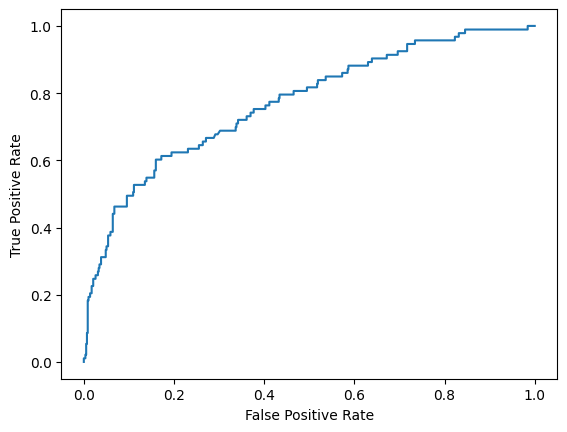

In [31]:
valid_label = validset.df['label'].apply(lambda x: validset.label_map[x]).tolist() # 文字 -> label id(0 or 1)

# 0: 低風險, 1: 中高風險
pred_prob_positive = [prob[1] for prob in pred_prob]
pred_prob_positive = np.array(pred_prob_positive)

fpr, tpr, thresholds = metrics.roc_curve(valid_label, pred_prob_positive, pos_label=1)
print('auc:', metrics.auc(fpr, tpr))

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [32]:
print(thresholds[tpr >= 0.4][0])
print(thresholds[tpr >= 0.5][0])
print(thresholds[tpr >= 0.6][0])
print(thresholds[tpr >= 0.7][0])
print(thresholds[tpr >= 0.8][0])
print(thresholds[tpr >= 0.9][0])

0.16098061203956604
0.13295593857765198
0.10303357243537903
0.06932202726602554
0.04792077839374542
0.03814150020480156


In [24]:
# testing result, up500.ckpt
prediction = [1 if prob[1] > 0.16098061203956604 else 0 for prob in pred_prob]
performance_fn(true_label, prediction) # left: true, top: pred, 0: 低風險, 1: 中高風險

prediction = [1 if prob[1] > 0.13295593857765198 else 0 for prob in pred_prob]
performance_fn(true_label, prediction)

prediction = [1 if prob[1] > 0.10303357243537903 else 0 for prob in pred_prob]
performance_fn(true_label, prediction)

prediction = [1 if prob[1] > 0.06932202726602554 else 0 for prob in pred_prob]
performance_fn(true_label, prediction)

prediction = [1 if prob[1] > 0.04792077839374542 else 0 for prob in pred_prob]
performance_fn(true_label, prediction)

prediction = [1 if prob[1] > 0.03814150020480156 else 0 for prob in pred_prob]
performance_fn(true_label, prediction)

Confusion matrix:
 [[653  72]
 [ 65  47]]
accuracy: 0.83632, True positive rate: 0.41964
Confusion matrix:
 [[621 104]
 [ 56  56]]
accuracy: 0.80884, True positive rate: 0.50000
Confusion matrix:
 [[587 138]
 [ 44  68]]
accuracy: 0.78256, True positive rate: 0.60714
Confusion matrix:
 [[443 282]
 [ 29  83]]
accuracy: 0.62843, True positive rate: 0.74107
Confusion matrix:
 [[334 391]
 [ 15  97]]
accuracy: 0.51493, True positive rate: 0.86607
Confusion matrix:
 [[230 495]
 [  8 104]]
accuracy: 0.39904, True positive rate: 0.92857


# Model performance

In [25]:
# final prediction
prediction = [1 if prob[1] > 0.16098061203956604 else 0 for prob in pred_prob]
# performance table
perf_df = dat_test.loc[:,['ID','label']]
perf_df.columns = ['ID', 'my_label']
perf_df.loc[:,'pred_label'] = prediction

# read data
tmp = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/屏東孤老/去識別化資料.xlsx',
                    sheet_name='109-110個管系統個案資料')
tmp2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/屏東孤老/去識別化資料.xlsx',
                     sheet_name='111年個管系統個案資料 ')
# rename cols
tmp = tmp.loc[:,['ID','級別']]
tmp2 = tmp2.loc[:,['ID','危險分級']]
tmp2.columns = ['ID', '級別']
print(tmp.shape)
print(tmp2.shape)
# rowbind [tmp, tmp2]
ID2they_label = pd.concat([tmp, tmp2]).reset_index(drop=True)
ID2they_label = ID2they_label.drop_duplicates(subset=['ID'], keep='last')
ID2they_label = ID2they_label[ID2they_label['ID'].isin(all_ID)].reset_index(drop=True) # 4183
print(ID2they_label.shape)
ID2they_label.loc[ID2they_label['級別'].str.contains('低危險'), '級別'] = '低風險'
ID2they_label.loc[~ID2they_label['級別'].str.contains('低風險'), '級別'] = '中高風險'
# update performance table
perf_df = perf_df.merge(ID2they_label, how='left', on='ID') # left join to perf_df
perf_df.columns = ['ID', 'my_label', 'pred_label', 'they_label']

# rename labels(text -> id(0,1))
label_map = {'低風險': 0, '中高風險': 1}
perf_df['my_label'] = perf_df['my_label'].apply(lambda x: label_map[x]).tolist()
perf_df['they_label'] = perf_df['they_label'].apply(lambda x: label_map[x]).tolist()

(1635, 2)
(3929, 2)
(4183, 2)


In [26]:
perf_df.head()

,ID,my_label,pred_label,they_label
0,T210001,1,1,0
1,T210004,0,0,0
2,T113626,0,0,0
3,T210013,0,0,0
4,S210017,0,0,0


In [27]:
my_label = perf_df['my_label'].tolist()
pred_label = perf_df['pred_label'].tolist()
they_label = perf_df['they_label'].tolist()

performance_fn(my_label, pred_label)
performance_fn(my_label, they_label)

Confusion matrix:
 [[653  72]
 [ 65  47]]
accuracy: 0.83632, True positive rate: 0.41964
Confusion matrix:
 [[701  24]
 [ 95  17]]
accuracy: 0.85783, True positive rate: 0.15179
